# Introduction to Business Analytics: Final Project 
Spring 2017 
***

## Introduction

Lending Club is an online credit marketplace that facilitates peer to peer lending by matching up investors and borrowers. Potential borrowers sign up to Lending Club and go through a quick approval process that allows them to request a personal, business, or medical loan.  Investors then make offers to borrowers based on their credit ratings and Lending Club’s suggested interest rates. Borrowers then begin to accept offers and have 15 days to reach a cumulative amount of at least 75% of their requested loan. The risk assessment process is automated and borrowers can begin to receive loan offers within minutes. (Lendingclub.com)

## The Business Problem

Unlike most banks and traditional lenders, Lending Club has a very flexible prepayment policy. Borrowers can prepay their loan at any time and without incurring a fee. Furthermore, investor fees may be reduced depending on the timing of the prepayment. Investors pay a payment processing fee equal to 1% of their monthly payment. If the loan is prepaid within the first 12 months then the investor only pays 1% of the contractual monthly payment and no fee is paid on the prepaid portion of the loan. However, if the loan is prepaid after the first 12 months then the investor pays a fee of 1% of the entire payment. In other words, if the borrower prepays during the first 12 months, Lending Club will only receive up to 33% and 20% of the total fee on a three- and five-year loan, respectively. If a loan is prepaid after the first 12 months then Lending Club will receive the entire fee. (For simplicity, we assume that any prepayments done during the first 12 months occur at the end of the 12th month.)

Prepayments can represent a significant loss in revenue for Lending Club. In its last 10-K, Lending Club reported service fees of 11.5m, 32.8m, and 68.0m dollars for 2014, 2015, and 2016, respectively. Additionally, data analysis shows that approximately X% of loans initiated in 201X were prepaid. This translates into a loss of up to XXM dollars for Lending club in 201X.
    
As Lending Club grows, the number of loans increase as do the number of prepayments. One solution to the problem is to implement a dynamic prepayment policy that would charge the borrower a prepayment fee based on the probability that the borrower prepays the loan. Lending club could maintain the 0% fee for borrowers less likely to prepay and charge a 1% fee for borrowers more likely to prepay. That way, in addition to protecting itself from a loss, Lending Club would make up to 33% more in fees on loans that were prepaid within the first 12 months.

## Data understanding

The Data

•	Please provide some notes (bullets are fine) on the features we selected… I’ll add the discussion about the timing

The Target Variable

•	Please provide the details on how we derive the target feature from current features.

Notes for profit curve to be done later:
1.	Assume 100 dollar loan
2.	Assume a probability that a borrower will not take out a loan if they have to pay a prepayment fee – this will represent a potential loss
3.	Assume a fee of 0% or 1%

Short cut cheatsheet: https://gist.github.com/kidpixo/f4318f8c8143adee5b40

## Data Preparation

### Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

# For file loading and memory monitoring
import os
import gc
import psutil
'''
    If you get error saying no module named psutil, run this in terminal :
    sudo su
    pip install psutil
'''

# collect garbage and check current memory
def collect_and_check_mem():
    proc = psutil.Process(os.getpid())
    gc.collect()
    mem = proc.memory_info().rss
    print ("Memory : %.2f MB" % (mem / (1000 * 1000)))
collect_and_check_mem()

Memory : 81.49 MB


In [2]:
# data loading util
def load_year_data(year, suffixs):
    loans_data = pd.DataFrame()
    for index in range(len(suffixs)):
        suffix = suffixs[index]
        path ="data/loans/%s/xa%s.csv.gz" % (year, suffix)
        if index == 0:
            loans_data = pd.read_csv(path, skiprows=1)
        else:
            frame = pd.read_csv(path, skiprows=0, names=loans_data.columns)
            loans_data = loans_data.append(frame, ignore_index=True)
            del frame
    return loans_data
# create suffix from start (e.g. 'a') to end (e.g. 'z')
def create_suffixs(start, end):
    return [chr(i) for i in range(ord(start), ord(end)+1)]

In [3]:
# 'a' to 'o' for 2015
suffixs = create_suffixs('a', 'o')
loans_data = load_year_data('2015', suffixs)
collect_and_check_mem()
len(loans_data.index)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Memory : 580.60 MB


421097

In [4]:
len(loans_data.columns)

111

###  Select features

In [5]:
# since too many features, maybe we take out those we wanna keep:
features_to_keep = set([
    # numerical
    'loan_amnt', 'funded_amnt', 'annual_inc', 'installment',
    'open_acc', 'total_acc',  
    
    # features used to extract target and drop once that done
    'loan_status',
    'last_pymnt_d', 
    'issue_d', 
    
    # categorical
    'term','home_ownership', 'purpose', 'application_type', # dummize
    'grade', 'sub_grade', 'verification_status', 
    'pymnt_plan',#binary
    # special
    #'title', # 10629 NULLs for 2016 Q1Q4 value maybe forget it
    
    'int_rate', 'revol_util', # trim out percentage mark: 10.65%
    'emp_length', # extracting number: 10+ years < 1 year
    
    # not sure and not processed:
    'inq_last_6mths', 'pub_rec', 'revol_bal', 'dti', 'delinq_2yrs', 
     'initial_list_status',
    'collections_12_mths_ex_med',
    'policy_code', 
    'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
    'pub_rec_bankruptcies', 'tax_liens'
    
    # confirmed to dropp:
    # 'addr_state', 
    # 'last_credit_pull_d', 'earliest_cr_line' # dates 'Mar-02'
])

In [6]:
len(features_to_keep)

33

In [7]:
for column in loans_data.columns:
    if column not in features_to_keep:
        loans_data = loans_data.drop(column, axis=1)
loans_data.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'last_pymnt_d', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens'],
      dtype='object')

In [8]:
len(loans_data.columns)

33

### Clean data

In [9]:
# Check NULL
loans_data.isnull().sum()

loan_amnt                       2
funded_amnt                     2
term                            2
int_rate                        2
installment                     2
grade                           2
sub_grade                       2
emp_length                      2
home_ownership                  2
annual_inc                      2
verification_status             2
issue_d                         2
loan_status                     2
pymnt_plan                      2
purpose                         2
dti                             2
delinq_2yrs                     2
inq_last_6mths                  2
open_acc                        2
pub_rec                         2
revol_bal                       2
revol_util                    164
total_acc                       2
initial_list_status             2
last_pymnt_d                  296
collections_12_mths_ex_med      2
policy_code                     2
application_type                2
acc_now_delinq                  2
chargeoff_with

In [10]:
# Drop rows with NULL values:
loans_data = loans_data.dropna()
total_num = len(loans_data.index)
#loans_data.isnull().sum()
total_num

420639

### Build Target Variable  

Target Variable:  <br>[loan_status="Fully Paid"] && [(last_pymnt_d - issue_d) < 366]

In [11]:
# loans_data["term"].unique()
# loans_data["last_pymnt_d"].unique()
# loans_data["issue_d"].unique()
loans_data["loan_status"].unique()

array(['Current', 'Fully Paid', 'Default', 'Charged Off',
       'Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period'], dtype=object)

In [12]:
# Target creation
from datetime import datetime
from random import randint

Y = [] # pre_paid : 1   not pre_paid : 0
for index in range(total_num):
    df = loans_data.iloc[index]
    if df["loan_status"] == "Fully Paid":
        time1 = datetime.strptime(df["issue_d"], '%b-%Y') # 'Feb-2017'
        time2 = datetime.strptime(df["last_pymnt_d"], '%b-%Y')
        diff = abs(time1 - time2).days
        if diff < 366:
            Y.insert(len(Y),1)    
        else:
            Y.insert(len(Y),0)
    else:
        Y.insert(len(Y),0)

In [13]:
# Remove target related features
for field in ['issue_d', 'loan_status', 'last_pymnt_d']:
    loans_data = loans_data.drop([field], axis=1)

In [14]:
# Target
len(Y)

420639

### Convert categorical features to numerical values  

In [15]:
# convert 'grade','subgrade' and 'verification status' into numerical values
loans_data['grade'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G'], [1,2,3,4,5,6,7], inplace = True)
loans_data['sub_grade'].replace(['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5','D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2','G3','G4','G5'
], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35], inplace = True)
loans_data['verification_status'].replace(['Not Verified', 'Source Verified', 'Verified'], [0,1,2], inplace = True)

In [16]:
loans_data['pymnt_plan'].unique()

array(['n', 'y'], dtype=object)

In [17]:
# convert 'pymnt_plan' to numeric values
loans_data['pymnt_plan'] = pd.Series(loans_data['pymnt_plan'] =='y',dtype=int)

In [18]:
loans_data['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

In [19]:
# conver 'initial_list_status' to numeric values
loans_data['initial_list_status'] = pd.Series(loans_data['initial_list_status'] =='w',dtype=int)

In [20]:
# creating dummy variables for 'term', 'home_ownership', 'purpose' and 'application type'
for field in ['term','home_ownership', 'purpose', 'application_type']:
    for value in loans_data[field].unique():
        loans_data[field + " _ " + value] = pd.Series(loans_data[field]==value, dtype=int)
    loans_data = loans_data.drop([field], axis=1)

In [21]:
# convert field with percentage mark to float
p_features = ['revol_util', 'int_rate']
for f in p_features:
    loans_data[f] = loans_data[f].replace('\%','', regex=True).astype(float)


In [22]:
loans_data['int_rate'].dtypes

dtype('float64')

In [23]:
loans_data['emp_length'].unique()

array(['5 years', '< 1 year', '3 years', '10+ years', '2 years', 'n/a',
       '4 years', '8 years', '6 years', '9 years', '1 year', '7 years'], dtype=object)

In [24]:

def extract_number(s):
    import re
    if isinstance(s, int):
        return s
    result = re.search('\d+', s)
    if result:
        return int(result.group())
    else:
        return 0 # default n/a for emp_length indicates no job
loans_data['emp_length'] = loans_data['emp_length'].apply(extract_number)

In [25]:
loans_data.head()

,loan_amnt,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,annual_inc,verification_status,pymnt_plan,...,purpose _ medical,purpose _ major_purchase,purpose _ house,purpose _ vacation,purpose _ moving,purpose _ renewable_energy,purpose _ wedding,purpose _ educational,application_type _ INDIVIDUAL,application_type _ JOINT
0,16000.0,16000.0,8.49,328.19,2,6,5,62000.0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,8000.0,8000.0,10.78,261.08,2,9,1,45000.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,10000.0,10000.0,10.78,326.35,2,9,3,41600.0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,24700.0,24700.0,11.99,820.28,3,11,10,65000.0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,10000.0,10000.0,11.99,222.40,3,11,10,42500.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
loans_data.shape

(420639, 48)

In [27]:
# Initiate model development
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import scale

In [28]:
# Scaling the data
X_Scaled = pd.DataFrame(scale(loans_data, axis=0, with_mean=True, with_std=True, copy=True), columns = loans_data.columns.values)

In [29]:
X_Scaled.shape

(420639, 48)

In [30]:
loans_data.describe()

,loan_amnt,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,annual_inc,verification_status,pymnt_plan,...,purpose _ medical,purpose _ major_purchase,purpose _ house,purpose _ vacation,purpose _ moving,purpose _ renewable_energy,purpose _ wedding,purpose _ educational,application_type _ INDIVIDUAL,application_type _ JOINT
count,420639.000000,420639.000000,420639.000000,420639.000000,420639.000000,420639.000000,420639.000000,4.206390e+05,420639.000000,420639.000000,...,420639.000000,420639.000000,420639.000000,420639.000000,420639.000000,420639.000000,420639.000000,420639.000000,420639.000000,420639.000000
mean,15241.623815,15241.623815,12.597062,441.869277,2.776725,11.838693,5.766741,7.695924e+04,1.010534,0.000005,...,0.009319,0.017668,0.003409,0.005330,0.005739,0.000530,0.000010,0.000002,0.998785,0.001215
std,8570.001535,8570.001535,4.316890,244.789384,1.303182,6.447744,3.750636,7.395647e+04,0.757255,0.002181,...,0.096085,0.131743,0.058288,0.072812,0.075538,0.023019,0.003084,0.001542,0.034833,0.034833
min,1000.000000,1000.000000,5.320000,14.010000,1.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8500.000000,8500.000000,9.170000,263.930000,2.000000,7.000000,2.000000,4.600000e+04,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,14000.000000,14000.000000,12.290000,385.460000,3.000000,11.000000,6.000000,6.500000e+04,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,20000.000000,20000.000000,15.590000,578.790000,4.000000,16.000000,10.000000,9.165700e+04,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,35000.000000,35000.000000,28.990000,1445.460000,7.000000,35.000000,10.000000,9.500000e+06,2.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
X_Scaled.describe()

,loan_amnt,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,annual_inc,verification_status,pymnt_plan,...,purpose _ medical,purpose _ major_purchase,purpose _ house,purpose _ vacation,purpose _ moving,purpose _ renewable_energy,purpose _ wedding,purpose _ educational,application_type _ INDIVIDUAL,application_type _ JOINT
count,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,...,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05,4.206390e+05
mean,8.055742e-16,8.055742e-16,3.035325e-14,-9.479861e-17,6.788159e-14,2.372194e-14,2.011743e-15,3.487264e-15,-4.210856e-15,-1.147581e-14,...,3.885984e-14,4.933984e-14,-5.513994e-15,8.486157e-15,7.453624e-15,4.371244e-15,2.782477e-15,5.326741e-15,-2.022587e-13,2.022587e-13
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.661801e+00,-1.661801e+00,-1.685721e+00,-1.747869e+00,-1.363376e+00,-1.681008e+00,-1.537538e+00,-1.040603e+00,-1.334472e+00,-2.180526e-03,...,-9.698875e-02,-1.341124e-01,-5.848727e-02,-7.320210e-02,-7.597376e-02,-2.303100e-02,-3.083737e-03,-1.541863e-03,-2.867348e+01,-3.487544e-02
25%,-7.866547e-01,-7.866547e-01,-7.938737e-01,-7.269085e-01,-5.960229e-01,-7.504484e-01,-1.004295e+00,-4.186149e-01,-1.334472e+00,-2.180526e-03,...,-9.698875e-02,-1.341124e-01,-5.848727e-02,-7.320210e-02,-7.597376e-02,-2.303100e-02,-3.083737e-03,-1.541863e-03,3.487544e-02,-3.487544e-02
50%,-1.448804e-01,-1.448804e-01,-7.113039e-02,-2.304403e-01,1.713305e-01,-1.300756e-01,6.219203e-02,-1.617067e-01,-1.391076e-02,-2.180526e-03,...,-9.698875e-02,-1.341124e-01,-5.848727e-02,-7.320210e-02,-7.597376e-02,-2.303100e-02,-3.083737e-03,-1.541863e-03,3.487544e-02,-3.487544e-02
75%,5.552370e-01,5.552370e-01,6.933097e-01,5.593416e-01,9.386840e-01,6.453904e-01,1.128679e+00,1.987355e-01,1.306651e+00,-2.180526e-03,...,-9.698875e-02,-1.341124e-01,-5.848727e-02,-7.320210e-02,-7.597376e-02,-2.303100e-02,-3.083737e-03,-1.541863e-03,3.487544e-02,-3.487544e-02
max,2.305530e+00,2.305530e+00,3.797400e+00,4.099818e+00,3.240744e+00,3.592161e+00,1.128679e+00,1.274135e+02,1.306651e+00,4.586049e+02,...,1.031047e+01,7.456431e+00,1.709774e+01,1.366081e+01,1.316244e+01,4.341974e+01,3.242819e+02,6.485661e+02,3.487544e-02,2.867348e+01


## Modeling

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

# Run this so your plots show properly
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12

X_train, X_test, Y_train, Y_test = train_test_split(X_Scaled, Y, train_size=0.8)

### Logistic Regression

In [33]:
# Logistic Regression model
c_values = []
alpha_values = []
for i in range(-5,5): 
    c_values.append(np.power(10.0, i))

lr_params = {
    "penalty": ['l2', 'l1'],
    "C": c_values
}
lr_model_search = GridSearchCV(LogisticRegression(), lr_params, scoring="roc_auc")
lr_model_search.fit(X_train, Y_train)
print("Linear regression best params:")
print(lr_model_search.best_params_)

Linear regression best params:


NameError: name 'lr_model_search' is not defined

In [34]:
lr_model = LogisticRegression(C=10, penalty='l1')
lr_model.fit(X_train, Y_train)
logistic_regression_accuracy = metrics.accuracy_score(lr_model.predict(X_test), Y_test)
print("Logistic regression accuracy: ")
print(logistic_regression_accuracy)

Logistic regression accuracy: 
0.878827500951


In [35]:
lr_model.coef_

array([[  2.99723766e-02,   1.35887569e-01,   4.10625627e-01,
         -2.40265622e-01,  -3.75253388e-02,  -4.26613419e-02,
          4.11819673e-02,   2.90814546e-02,   1.54559558e-02,
         -1.45834877e-02,  -4.89680158e-01,  -8.88450269e-02,
          1.48414921e-02,  -1.91707844e-01,  -1.56856809e-01,
          4.79826847e-02,  -2.68283884e-01,   2.92900910e-01,
         -1.29955041e-03,  -4.55521144e-02,   0.00000000e+00,
         -1.77851375e-02,  -9.31715414e-03,   3.40060419e-03,
          7.61769707e-02,   1.63622418e-02,  -1.72554757e-01,
          1.52495847e-01,   3.87852821e-02,  -6.20243883e-02,
          0.00000000e+00,  -1.43365349e-02,  -3.95644706e-02,
          2.24457535e-02,  -3.45752636e-02,  -2.23434857e-04,
         -9.28465771e-03,  -1.24665610e-03,  -1.03835511e-02,
         -5.60459048e-03,   8.53166500e-03,   1.39378707e-03,
         -1.20444082e-03,  -2.93921988e-03,  -2.38405699e-02,
         -9.15131303e-03,  -5.36482980e-06,   1.54455576e-03]])

In [36]:
X_Scaled.columns

Index(['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'annual_inc', 'verification_status',
       'pymnt_plan', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'term _  60 months',
       'term _  36 months', 'home_ownership _ MORTGAGE',
       'home_ownership _ RENT', 'home_ownership _ OWN', 'home_ownership _ ANY',
       'purpose _ credit_card', 'purpose _ debt_consolidation',
       'purpose _ small_business', 'purpose _ car', 'purpose _ other',
       'purpose _ home_improvement', 'purpose _ medical',
       'purpose _ major_purchase', 'purpose _ house', 'purpose _ vacation',
       'purpose _ moving', 'purpose _ renewable_energy', 'purpose _ wedding',
       'purpose _ educational', 'ap

### Decision Tree

In [37]:
# Decision Tree model
def decision_tree_params(data):
    min_samples_split_values = []
    min_samples_leaf_values = []
    total = len(data.index)
    n = int(np.log10(total))
    for i in range(0, n):
        total /= 10 
        min_samples_split_values.append(int(total))
        min_samples_leaf_values.append(int(total))
    return {
        "min_samples_split": min_samples_split_values,
        "min_samples_leaf": min_samples_leaf_values
    }
            
dt_params = decision_tree_params(X_train)

dt_model_search = GridSearchCV(DecisionTreeClassifier(), dt_params, scoring="roc_auc")
dt_model_search.fit(X_train, Y_train)
print("Decision tree best params:")
print(dt_model_search.best_params_)

KeyboardInterrupt: 

In [38]:
dt_model = DecisionTreeClassifier(min_samples_split=3365) # the best params min_samples_leaf given by GridSearch will overfit
dt_model.fit(X_train, Y_train)
decision_tree_accuracy = metrics.accuracy_score(dt_model.predict(X_test), Y_test)
print("Decision tree accuracy: ")
print(decision_tree_accuracy)

Decision tree accuracy: 
0.87894636744


## Evaluation

### ROC curve

In [39]:
tprs = []
fprs = []
roc_labels = []
model_labels = ["Logistic Regression", "Decision Tree"]
for m_index in range(2):
    model = lr_model if m_index == 0 else dt_model
    model_label = model_labels[m_index]
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(model.predict(X_test), Y_test)
    tprs.append(tpr)
    fprs.append(fpr)
    graph_label = "%s_%.3f" % (model_label, auc)
    roc_labels.append(graph_label)

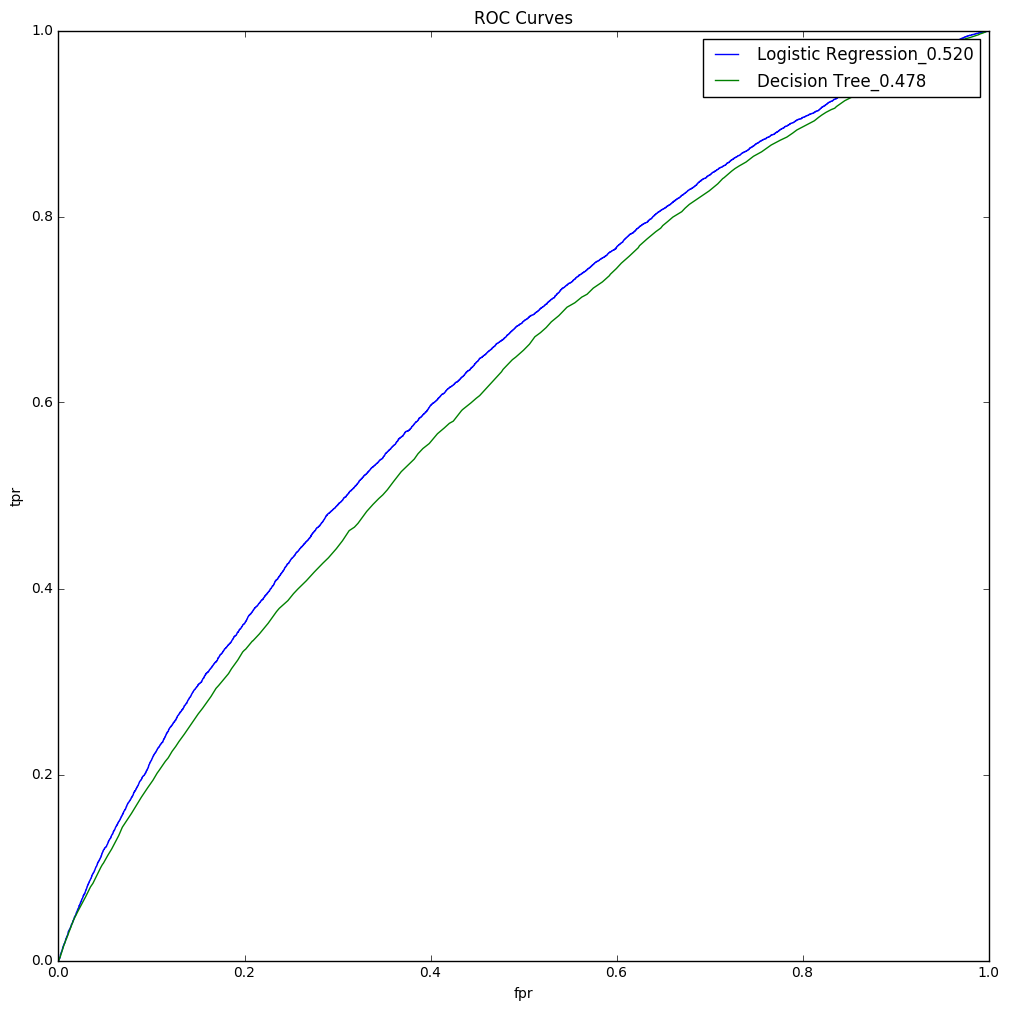

In [40]:
# plot the roc data
for fpr, tpr, roc_label in zip(fprs, tprs, roc_labels):
    plt.plot(fpr, tpr, label=roc_label)

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend()
plt.xlim([0, 1])
plt.show()

In [41]:
len(Y_train)

336511

### Learning Curve

In [43]:
sample_sizes = []
limit = 200000
while limit > 10000:
    sample_sizes.append(int(limit))
    limit /= 1.5
print (sample_sizes)

dt_train_sizes, dt_train_scores, dt_test_scores = learning_curve(dt_model,
                                                                 X_train,
                                                                 Y_train,
                                                                 cv=3,
                                                                 train_sizes=sample_sizes, 
                                                                 scoring='roc_auc')
lr_train_sizes, lr_train_scores, lr_test_scores = learning_curve(lr_model,
                                                                 X_train,
                                                                 Y_train,
                                                                 cv=3,
                                                                 train_sizes=sample_sizes, 
                                                                 scoring='roc_auc')
plt.xlabel("sample sizes")
plt.ylabel("roc_auc")
plt.errorbar(dt_train_sizes, 
             np.mean(dt_train_scores, axis=1), 
             yerr=np.std(dt_train_scores, axis=1), 
             color="red", 
             label="Decision Tree")
plt.errorbar(lr_train_sizes, 
             np.mean(lr_train_scores, axis=1), 
             yerr=np.std(lr_train_scores, axis=1), 
             color="blue", label="Logistic Regression")
plt.legend(loc=0)

[200000, 133333, 88888, 59259, 39506, 26337, 17558, 11705]


KeyboardInterrupt: 

### Cost Matrix

In [44]:
cost_matrix_movies = pd.DataFrame([[0.88, -.12], [0, 0]], columns=['p', 'n'], index=['Y','N'])

print (cost_matrix_movies)

      p     n
Y  0.88 -0.12
N  0.00  0.00


### Profit Curve

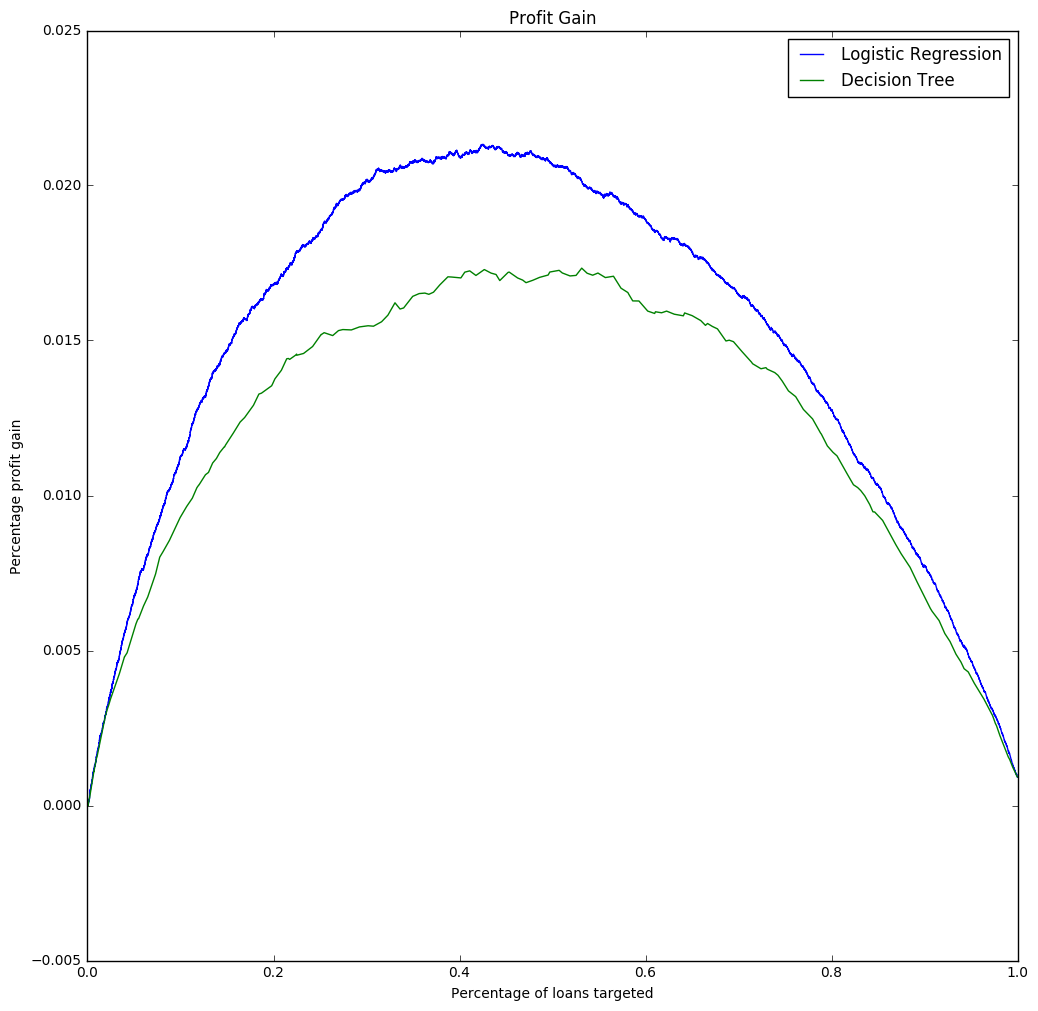

In [46]:
# baseline probability of being positive or negative in test
p_p = np.sum(Y_test)/float(len(Y_test))
p_n = 1 - np.sum(Y_test)/float(len(Y_test))
size_targeted_pop = float(len(Y_test))

for m_index in range(2):
    model = lr_model if m_index == 0 else dt_model
    model_label = model_labels[m_index]
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
    Y_test_predicted = model.predict(X_test)
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Reviews above the current threshold
    n_targeted = []
    for t in thresholds:
        n_targeted.append(np.sum(Y_test_probability_1 >= t))

    # Turn these counts to percentages of reviews above the threshold
    n_targeted = np.array(n_targeted) / size_targeted_pop

    # Expected profits:  
    expected_profits = ((cost_matrix_movies['p']['Y'] * (tpr * p_p)) + (cost_matrix_movies['n']['Y'] * (fpr * p_n)))/size_targeted_pop

    # Plot the profit curve
    plt.plot(n_targeted, size_targeted_pop * expected_profits, label="%s" % (model_label))

plt.xlabel("Percentage of loans targeted")
plt.ylabel("Percentage profit gain")
plt.legend()
plt.title("Profit Gain")



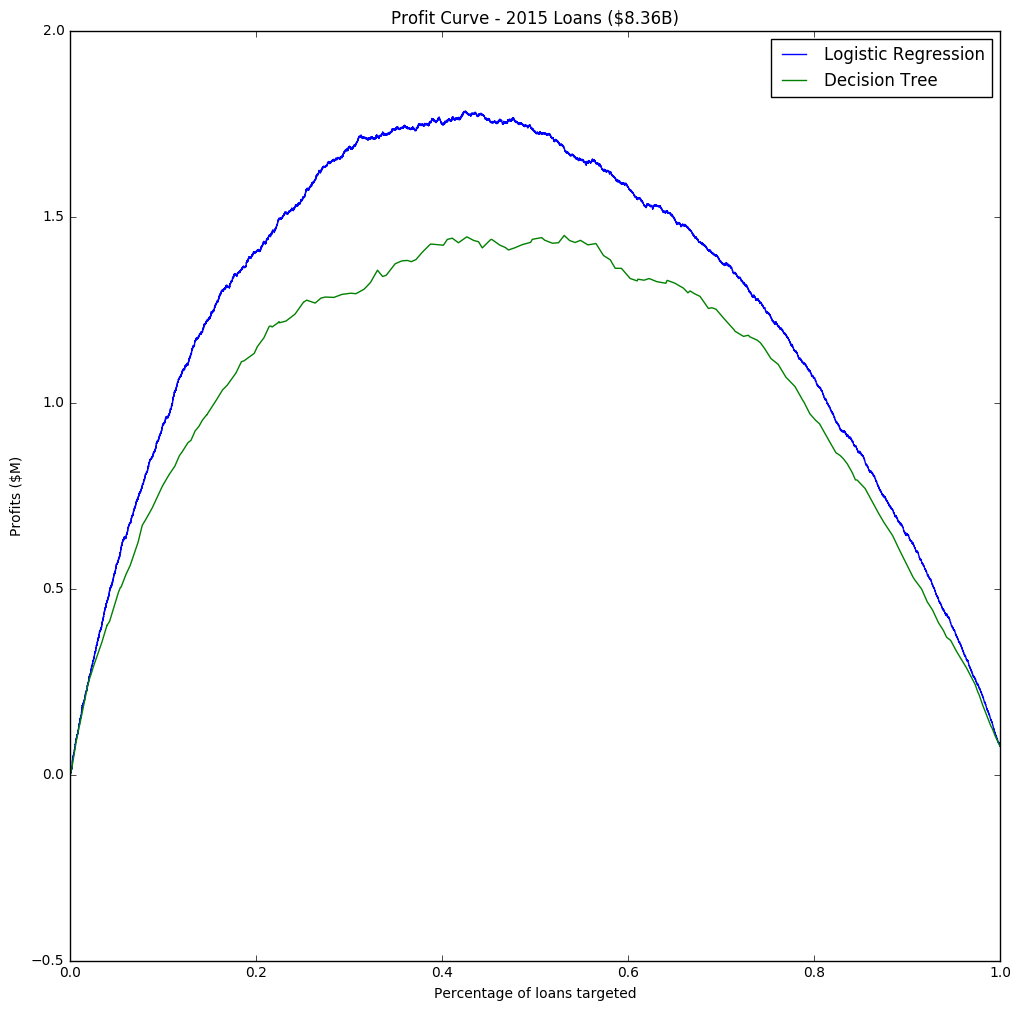

In [50]:
# baseline probability of being positive or negative in test
p_p = np.sum(Y_test)/float(len(Y_test))
p_n = 1 - np.sum(Y_test)/float(len(Y_test))
size_targeted_pop = float(len(Y_test))

for m_index in range(2):
    model = lr_model if m_index == 0 else dt_model
    model_label = model_labels[m_index]
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
    Y_test_predicted = model.predict(X_test)
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Reviews above the current threshold
    n_targeted = []
    for t in thresholds:
        n_targeted.append(np.sum(Y_test_probability_1 >= t))

    # Turn these counts to percentages of reviews above the threshold
    n_targeted = np.array(n_targeted) / size_targeted_pop

    # Expected profits:  
    expected_profits = ((cost_matrix_movies['p']['Y'] * (tpr * p_p)) + (cost_matrix_movies['n']['Y'] * (fpr * p_n)))/size_targeted_pop

    # Plot the profit curve
    plt.plot(n_targeted, size_targeted_pop * expected_profits * 83.60, label="%s" % (model_label))

plt.xlabel("Percentage of loans targeted")
plt.ylabel("Profits ($M)")
plt.legend()
plt.title("Profit Curve - 2015 Loans ($8.36B)")
